# Run Validation

In [1]:
include("validation.jl")
models = load_models()
modelnames = sort!(collect(keys(models)), rev=true)

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in super(::DataType) at ./deprecated.jl:50
 in variate_form at /Users/jeremymorton/.julia/v0.5/Distributions/src/common.jl:57 [inlined] (repeats 2 times)
 in Type at /Users/jeremymorton/.julia/v0.5/Distributions/src/mixtures/mixturemodel.jl:36 [inlined]
 in Distributions.MixtureModel{VF<:Distributions.VariateForm,VS<:Distributions.ValueSupport,C<:Distributions.Distribution}(::Array{Distributions.MvNormal,1}, ::Array{Float64,1}) at /Users/jeremymorton/.julia/v0.5/Distributions/src/mixtures/mixturemodel.jl:41
 in read(::IOStream, ::Type{AutoDrivers.GaussianMixtureRegressionDrivers.GMR}, ::Array{String,1}, ::Int64) at /Users/jeremymorton/.julia/v0.5/AutoDrivers/src/GaussianMixtureRegressionDrivers/io.jl:100
 in read(::IOStream, ::Type{AutoDrivers.GaussianMixtureRegressionDrivers.GaussianMixtureRegressionDriver}, ::MultiFeatureExtractor) at /Users/jeremymorton/.julia/v0.5/AutoDrivers/src/GaussianMixtureRegressionDrivers/io.jl:157
 in o

1-element Array{AbstractString,1}:
 "GMR"

In [2]:
for model in modelnames
    validate(models[model], save=true, modelname=model)
    println(model)
end

GMR


# Visualize Policy

In [3]:
using AutoViz, Interact

 in depwarn(::

String, ::Symbol) at ./deprecated.jl:64
 in readall(::String) at ./deprecated.jl:30
 in include_from_node1(::String) at ./loading.jl:488
 in include_from_node1(::String) at /Applications/Julia-0.5.app/Contents/Resources/julia/lib/julia/sys.dylib:?
 in __init__() at /Users/jeremymorton/.julia/v0.5/Interact/src/Interact.jl:81
 in include_from_node1(::String) at ./loading.jl:488
 in include_from_node1(::String) at /Applications/Julia-0.5.app/Contents/Resources/julia/lib/julia/sys.dylib:?
 in eval(::Module, ::Any) at ./boot.jl:234
 in eval(::Module, ::Any) at /Applications/Julia-0.5.app/Contents/Resources/julia/lib/julia/sys.dylib:?
 in require(::Symbol) at ./loading.jl:415
 in require(::Symbol) at /Applications/Julia-0.5.app/Contents/Resources/julia/lib/julia/sys.dylib:?
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/jeremymorton/.julia/v0.5/IJulia/src/execute_request.jl:169
 in eventloop(::ZMQ.Socket) at /Users/jeremym

In [4]:
env_dict = Dict("trajdata_indeces" => [1],
                       "use_playback_reactive" => true,
                       "extract_core" => true,
                       "extract_temporal" => false,
                       "extract_well_behaved" => true,
                       "extract_neighbor_features" => false,
                       "extract_carlidar_rangerate" => true,
                       "carlidar_nbeams" => 20,
                       "roadlidar_nbeams" => 0,
                       "roadlidar_nlanes" => 2,
                       "nsteps" => 100,
                       "carlidar_max_range" => 100.0,
                       "roadlidar_max_range" => 100.0,
"model_all" => false)
simparams = Auto2D.gen_simparams(1, env_dict)

loading trajdatas: [1]
elapsed time: 6.552839349 seconds
loading training segments
elapsed time: 42.658388595 seconds


SimParams

In [7]:
# simparams.driver_model = Auto2D.load_gru_driver("./models/Dec11/policy_temp0_100.h5", 319);
model = models["bc_mlp"]
reset(simparams)
simstate = simparams.simstates[1]
trajdata = simparams.trajdatas[simstate.trajdata_index]
reset_hidden_state!(model)
empty!(simstate.rec)

if Symbol("gru") in fieldnames(model.net)
    model.net[:gru].h_prev = zeros(length(model.net[:gru].h_prev))
end
observe!(model, simparams, simstate.scene, trajdata.roadway, simstate.egoid)
sim_rec = SceneRecord(200, 0.1)
for t = 1:200
    ego_action = rand(model)
    a = clamp(ego_action.a, -5.0, 3.0)
    ω = clamp(ego_action.ω, -0.1, 0.1)
    step(simparams, [a, ω])
    observe!(model, simparams, simstate.scene, trajdata.roadway, simstate.egoid)
    update!(sim_rec, simstate.scene)
end

Interact.Slider{Int64}(Signal{Int64}(-100, nactions=0),"pastframe",-100,-199:0,true)

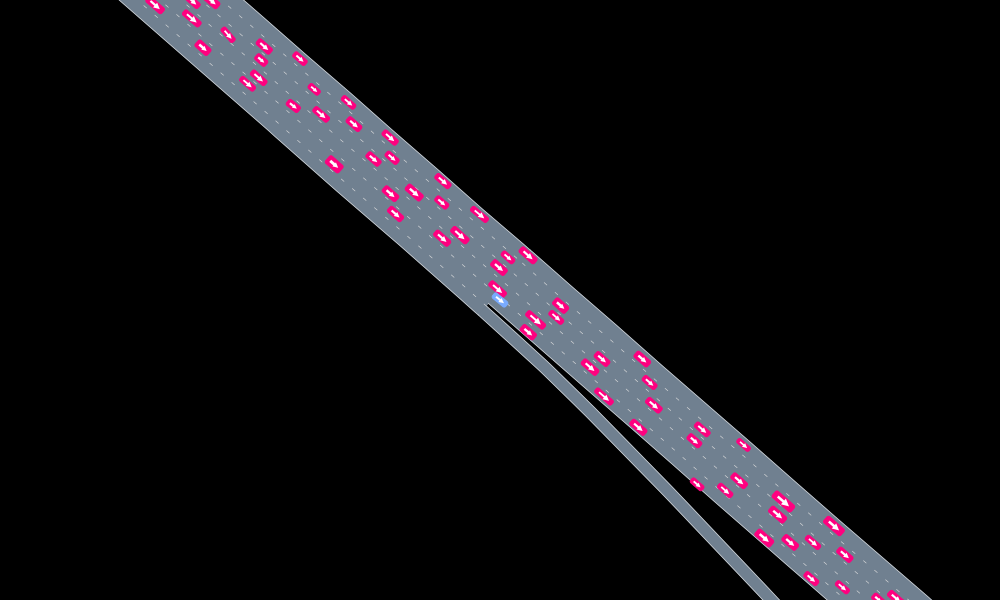

In [8]:
scene = simparams.simstates[1].scene
egoid = simparams.simstates[1].egoid
trajdata = simparams.trajdatas[1]
@manipulate for pastframe in -length(sim_rec)+1 : 0
    render(get!(scene, sim_rec, pastframe), trajdata.roadway, cam=CarFollowCamera(egoid, 4.0), 
       car_colors=Dict{Int,Colorant}(egoid=>COLOR_CAR_EGO))
end